# <font color ='blue'>Zillow Regression Project - Working Copy

In [1]:
# import pandas and numpy to start coding
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# prep methods
from sklearn.model_selection import train_test_split

# Feature Engineering methods
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing

# Modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

import warnings
warnings.filterwarnings("ignore")

# <font color = 'red'>Planning

### Project Goals

- A model that predicts property tax assessed values of single family properties based on 2017 transactions.
- Identify ways to make a better model for Zillow.
- Create new features out of existing features.
- Try non-linear regression model or try a model for each county.


### Project Description

Deliver:
1. Github Repo
    - README.md
    - Final Report
    - Working Notebooks
    - Acquire and Prepare Modules
    - Misc Artifacts
1. Regression Model (Linear or Non-Linear)
2. Final Notebook with Recommendation
    - 4 Visuals, 2 with stats tests
        - Data Context of Target Variable (Distribution of values)
    - 3 Best Models (show steps/code to fit/eval/select)
    - Visual of how best Model performed
3. Working Notebook:
    - Reproducible comments
    - Exploration with at least two stats test during exploration
5. Presentation
    - Findings
    - Methodologies
    - Conclusions

### Initial Questions

- What are the transactions are in 2017?
- What states and counties are the properties located in?
- What is the tax rate per county or fips? (might have to combine columns to calcualate)
- What is the distribution of tax rates for each county?
- What is the distribution of taxes across fips?
- What are the drivers of single family property values?
- Why do some properties have a much higher value than others when they are located so close to each other?
- Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? 
- Is having 1 bathroom worse than having 2 bedrooms?

### Data Dictionary (Add to README)

In [2]:
# Read Data Dictionary from working directory
dd = pd.read_excel('zillow_data_dictionary.xlsx')
dd

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (i...
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, ..."
2,'basementsqft',Finished living area below or partially below...
3,'bathroomcnt',Number of bathrooms in home including fractio...
4,'bedroomcnt',Number of bedrooms in home
5,'buildingqualitytypeid',Overall assessment of condition of the buildi...
6,'buildingclasstypeid',"The building framing type (steel frame, wood f..."
7,'calculatedbathnbr',Number of bathrooms in home including fractio...
8,'decktypeid',Type of deck (if any) present on parcel
9,'threequarterbathnbr',Number of 3/4 bathrooms in house (shower + si...


# <font color = 'red'> Acquisition (Get and Clean Data)

## <font color = 'red'>Get Data

- Added env.py to the repo .gitignore file so env.py won't be pushed to github
- Created an env file that contains my username, password, and host address fo the MySQL Server.

In [3]:
# import env file for hostname, username, password, and db_name
from env import host, user, password, db_name

In [4]:
# Pass env file authentication to container 'url'
url = f'mysql+pymysql://{user}:{password}@{host}/{db_name}'

### Pull records of houses with transactions from 2017

In [5]:
# define sql search for all records from all tables
sql ='''
SELECT prop17.parcelid, prop17.calculatedfinishedsquarefeet,
prop17.yearbuilt, prop17.bedroomcnt, prop17.bathroomcnt, prop17.taxvaluedollarcnt, prop17.fips,
prop17.regionidzip, prop17.regionidneighborhood, prop17.poolcnt,
prop17.lotsizesquarefeet, prop17.garagecarcnt, prop17.longitude, prop17.latitude,
pred17.transactiondate
FROM properties_2017 prop17
JOIN predictions_2017 pred17  USING (parcelid)
LEFT JOIN propertylandusetype using (propertylandusetypeid)
WHERE propertylandusetypeid='261'
'''

#### Note: Removed LIKE '2017%' since it resulted in error  for unknown support  for (''')

### Take Aways:
- Identified the following list but limited IAW project guidelines:
    - pred17.id, pred17.parcelid, pred17.transactiondate, prop17.calculatedfinishedsquarefeet, 
prop17.yearbuilt, prop17.bedroomcnt, prop17.bathroomcnt, prop17.taxvaluedollarcnt, prop17.taxamount, 
prop17.fips, prop17.regionidzip, prop17.lotsizesquarefeet, prop17.poolcnt, prop17.fireplacecnt
- Sencond run: added the above columns

In [6]:
# load zillow data from saved csv or pull from sql server and save to csv
import os
file = 'zillow_data.csv'
if os.path.isfile(file):
    df = pd.read_csv(file, index_col=0)
else:
    df = pd.read_sql(sql,url)
    df.to_csv(file)
df.head()

,parcelid,calculatedfinishedsquarefeet,yearbuilt,bedroomcnt,bathroomcnt,taxvaluedollarcnt,regionidzip,regionidneighborhood,poolcnt,lotsizesquarefeet,garagecarcnt,longitude,latitude,transactiondate
0,14297519,3100.0,1998.0,4.0,3.5,1023282.0,96978.0,NaN,NaN,4506.0,2.0,-117869207.0,33634931.0,2017-01-01
1,17052889,1465.0,1967.0,2.0,1.0,464000.0,97099.0,NaN,NaN,12647.0,1.0,-119281531.0,34449266.0,2017-01-01
2,14186244,1243.0,1962.0,3.0,2.0,564778.0,97078.0,NaN,1.0,8432.0,2.0,-117823170.0,33886168.0,2017-01-01
3,12177905,2376.0,1970.0,4.0,3.0,145143.0,96330.0,NaN,1.0,13038.0,NaN,-118240722.0,34245180.0,2017-01-01
4,12095076,2962.0,1950.0,4.0,3.0,773303.0,96293.0,274684.0,1.0,63000.0,NaN,-118179824.0,34145202.0,2017-01-01


### Show df info()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52442 non-null  int64  
 1   calculatedfinishedsquarefeet  52360 non-null  float64
 2   yearbuilt                     52326 non-null  float64
 3   bedroomcnt                    52442 non-null  float64
 4   bathroomcnt                   52442 non-null  float64
 5   taxvaluedollarcnt             52441 non-null  float64
 6   regionidzip                   52416 non-null  float64
 7   regionidneighborhood          19033 non-null  float64
 8   poolcnt                       11096 non-null  float64
 9   lotsizesquarefeet             52073 non-null  float64
 10  garagecarcnt                  18015 non-null  float64
 11  longitude                     52442 non-null  float64
 12  latitude                      52442 non-null  float64
 13  t

### Take Aways:
- 52.5K records

In [8]:
df.isnull().sum()

parcelid                            0
calculatedfinishedsquarefeet       82
yearbuilt                         116
bedroomcnt                          0
bathroomcnt                         0
taxvaluedollarcnt                   1
regionidzip                        26
regionidneighborhood            33409
poolcnt                         41346
lotsizesquarefeet                 369
garagecarcnt                    34427
longitude                           0
latitude                            0
transactiondate                     0
dtype: int64

### Take Aways:
- Too many nulls in neighborhood, pools, fireplace, garage
### What is the range of the transaction date? Found that 

In [9]:
df.transactiondate.min(), df.transactiondate.max()

('2017-01-01', '2018-05-25')

- Found that 2018 transactions exist
### What are the 2018 Transactions?

In [10]:
df[df.transactiondate.str.contains('2018')]

,parcelid,calculatedfinishedsquarefeet,yearbuilt,bedroomcnt,bathroomcnt,taxvaluedollarcnt,regionidzip,regionidneighborhood,poolcnt,lotsizesquarefeet,garagecarcnt,longitude,latitude,transactiondate
52441,13083743,1050.0,1960.0,3.0,2.0,259334.0,96488.0,NaN,NaN,5927.0,NaN,-117900894.0,34010864.0,2018-05-25


- Found one record
### Remove record from df

In [11]:
df = df.drop(index=52441)
df[df.transactiondate.str.contains('2018')]

,parcelid,calculatedfinishedsquarefeet,yearbuilt,bedroomcnt,bathroomcnt,taxvaluedollarcnt,regionidzip,regionidneighborhood,poolcnt,lotsizesquarefeet,garagecarcnt,longitude,latitude,transactiondate


- Confirmed 2018 record was remove

### Create Functions to Get Zillow Data

## <font color = 'red'> Clean Data

In [12]:
df.head()

,parcelid,calculatedfinishedsquarefeet,yearbuilt,bedroomcnt,bathroomcnt,taxvaluedollarcnt,regionidzip,regionidneighborhood,poolcnt,lotsizesquarefeet,garagecarcnt,longitude,latitude,transactiondate
0,14297519,3100.0,1998.0,4.0,3.5,1023282.0,96978.0,NaN,NaN,4506.0,2.0,-117869207.0,33634931.0,2017-01-01
1,17052889,1465.0,1967.0,2.0,1.0,464000.0,97099.0,NaN,NaN,12647.0,1.0,-119281531.0,34449266.0,2017-01-01
2,14186244,1243.0,1962.0,3.0,2.0,564778.0,97078.0,NaN,1.0,8432.0,2.0,-117823170.0,33886168.0,2017-01-01
3,12177905,2376.0,1970.0,4.0,3.0,145143.0,96330.0,NaN,1.0,13038.0,NaN,-118240722.0,34245180.0,2017-01-01
4,12095076,2962.0,1950.0,4.0,3.0,773303.0,96293.0,274684.0,1.0,63000.0,NaN,-118179824.0,34145202.0,2017-01-01


### Rename columns for Readability

In [13]:
df.columns.to_list()

['parcelid',
 'calculatedfinishedsquarefeet',
 'yearbuilt',
 'bedroomcnt',
 'bathroomcnt',
 'taxvaluedollarcnt',
 'regionidzip',
 'regionidneighborhood',
 'poolcnt',
 'lotsizesquarefeet',
 'garagecarcnt',
 'longitude',
 'latitude',
 'transactiondate']

In [14]:
# rename columns for readability
df = df.rename(columns = {'parcelid':'parcel_id',
                          'calculatedfinishedsquarefeet':'area',
                          'yearbuilt':'year_built',
                          'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms',
                          'taxvaluedollarcnt':'tax_value',
                          'taxamount':'tax_amount',
                          'transactiondate':'transaction_date',
                          'regionidzip':'zipcode',
                             'regionidneighborhood':'neighborhood',
                             'poolcnt':'pools',
                             'lotsizesquarefeet':'lot_size',
                          'garagecarcnt':'garages'
                         })

### Check Columns Names Changed

In [15]:
df.columns

Index(['parcel_id', 'area', 'year_built', 'bedrooms', 'bathrooms', 'tax_value',
       'zipcode', 'neighborhood', 'pools', 'lot_size', 'garages', 'longitude',
       'latitude', 'transaction_date'],
      dtype='object')

### Dropping transaction_date, and parcel_id columns since it doens't help with explore or modeling

In [16]:
df = df.drop(columns=['transaction_date', 'parcel_id'])
df.columns

Index(['area', 'year_built', 'bedrooms', 'bathrooms', 'tax_value', 'zipcode',
       'neighborhood', 'pools', 'lot_size', 'garages', 'longitude',
       'latitude'],
      dtype='object')

### Show describe without scientific notation

In [17]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,area,year_built,bedrooms,bathrooms,tax_value,zipcode,neighborhood,pools,lot_size,garages,longitude,latitude
count,52359,52325,52441,52441,52440,52415,19033,11096,52072,18015,52441,52441
mean,1922.89,1963.39,3.30068,2.2994,529688,96635.8,180267,1,11339.6,1.94899,-1.18194e+08,3.40225e+07
std,1004.37,23.1336,0.949094,1.02277,751895,4605.11,159825,0,86747.6,0.549944,356663,273979
min,128,1878,0,0,1000,95982,6952,1,236,0,-1.19475e+08,3.33406e+07
25%,1268,1950,3,2,193748,96206,41131,1,5583,2,-1.18401e+08,3.38269e+07
50%,1659,1961,3,2,373612,96412,118208,1,6840.5,2,-1.18153e+08,3.40238e+07
75%,2306,1979,4,3,619301,96995,274514,1,8798.25,2,-1.17929e+08,3.41872e+07
max,21929,2016,14,18,4.90612e+07,399675,764167,1,6.97101e+06,14,-1.17555e+08,3.48188e+07


### Take Away: 
- Huge Skew in tax value, area, lot_size
- Counts are off in multiple columns
- bedrooms and bathroom contain zero
### Change Blanks to Nulls

In [18]:
df = df.replace('', np.nan)

### Check for Nulls

In [19]:
df.isnull().sum()

area               82
year_built        116
bedrooms            0
bathrooms           0
tax_value           1
zipcode            26
neighborhood    33408
pools           41345
lot_size          369
garages         34426
longitude           0
latitude            0
dtype: int64

In [20]:
value_cols = df.drop(columns=['area','year_built','tax_value','lot_size'])

In [21]:
for col in value_cols:
    print(f'----------------{col}--------------------')
    print(df[col].value_counts())

----------------bedrooms--------------------
3.0     23359
4.0     15240
2.0      8340
5.0      3973
6.0       635
1.0       612
0.0       137
7.0       106
8.0        24
9.0         8
12.0        3
10.0        2
14.0        1
11.0        1
Name: bedrooms, dtype: int64
----------------bathrooms--------------------
2.0     21893
3.0     10673
1.0      9568
2.5      3934
4.0      2227
3.5       918
1.5       841
5.0       803
4.5       687
6.0       322
5.5       224
0.0       121
7.0        88
8.0        53
6.5        47
7.5        16
9.0        13
10.0        5
8.5         3
11.0        3
18.0        1
13.0        1
Name: bathrooms, dtype: int64
----------------zipcode--------------------
97319.0    776
97318.0    674
97329.0    564
97328.0    519
97118.0    498
          ... 
97088.0      1
97092.0      1
96038.0      1
96467.0      1
96148.0      1
Name: zipcode, Length: 381, dtype: int64
----------------neighborhood--------------------
48570.0     503
118208.0    476
27080.0     448

In [22]:
df.isna().sum()

area               82
year_built        116
bedrooms            0
bathrooms           0
tax_value           1
zipcode            26
neighborhood    33408
pools           41345
lot_size          369
garages         34426
longitude           0
latitude            0
dtype: int64

In [23]:
df.shape

(52441, 12)

### Replaced Pool NaN with 0

In [24]:
# replace pool, lot_size, l nan with 0
df.pools = df.pools.replace(np.nan, 0)

In [25]:
df.pools.isna().sum()

0

In [26]:
df.shape

(52441, 12)

### Replace lot_size with median, 6,384

<AxesSubplot:>

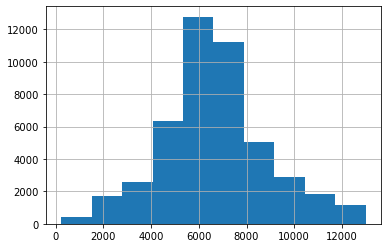

In [27]:
df[df.lot_size < 13000].lot_size.hist()

In [28]:
# replace lot_size, lot_size, l nan with meian
df.lot_size = df.lot_size.replace(np.nan, df.lot_size.mean())
df.lot_size.isna().sum()

0

In [29]:
df.shape

(52441, 12)

### Replace Zipcode NaN

In [30]:
df.zipcode.describe()

count     52415.000000
mean      96635.846380
std        4605.107533
min       95982.000000
25%       96206.000000
50%       96412.000000
75%       96995.000000
max      399675.000000
Name: zipcode, dtype: float64

<AxesSubplot:>

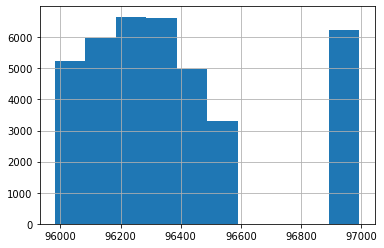

In [31]:
df[df.zipcode < 96995].zipcode.hist()

<AxesSubplot:>

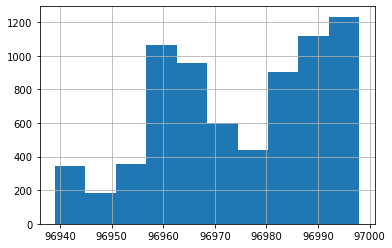

In [32]:
df[(df.zipcode > 96600) & (df.zipcode < 97000)].zipcode.hist()

<AxesSubplot:>

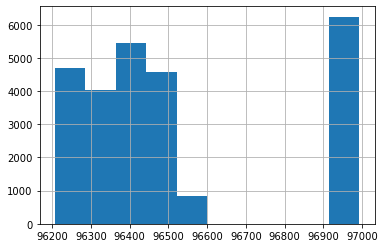

In [33]:
df[(df.zipcode > 96206) & (df.zipcode < 96995)].zipcode.hist()

### Drop records with zipcode NaN, not useful 

### Replace year_built

<AxesSubplot:>

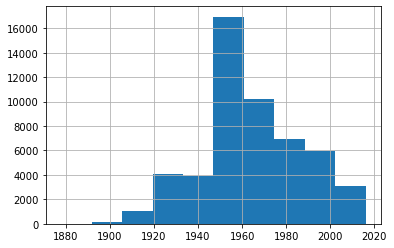

In [34]:
df.year_built.hist()

In [35]:
df.year_built.describe()

count    52325.000000
mean      1963.393884
std         23.133571
min       1878.000000
25%       1950.000000
50%       1961.000000
75%       1979.000000
max       2016.000000
Name: year_built, dtype: float64

In [36]:
df.year_built.value_counts()

1955.0    1899
1950.0    1608
1954.0    1520
1953.0    1485
1956.0    1387
          ... 
1897.0       1
1882.0       1
1894.0       1
1880.0       1
1889.0       1
Name: year_built, Length: 133, dtype: int64

In [37]:
#Set year_built to 1955, most used year
df.year_built = df.year_built.replace(np.nan, 1955)

In [40]:
df.isna().sum()

area               82
year_built          0
bedrooms            0
bathrooms           0
tax_value           1
zipcode            26
neighborhood    33408
pools               0
lot_size            0
garages         34426
longitude           0
latitude            0
dtype: int64

### Replace area NaN with most used 

In [42]:
df.area.describe()

count    52359.000000
mean      1922.890754
std       1004.365838
min        128.000000
25%       1268.000000
50%       1659.000000
75%       2306.000000
max      21929.000000
Name: area, dtype: float64

<AxesSubplot:>

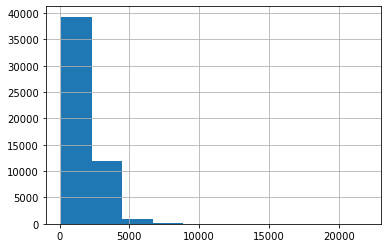

In [47]:
df.area.hist()

<AxesSubplot:>

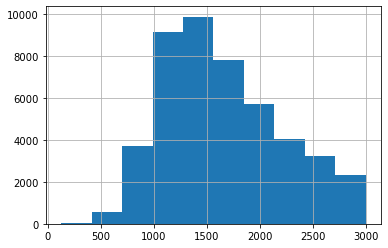

In [50]:
df[df.area < 3000].area.hist()

<AxesSubplot:>

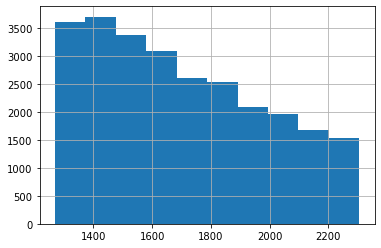

In [46]:
df[(df.area > 1268) & (df.area < 2306)].area.hist()

In [58]:
df.area.value_counts()

1120.0    128
1200.0    119
1080.0    102
1040.0     86
936.0      86
         ... 
524.0       1
5119.0      1
6649.0      1
3491.0      1
3943.0      1
Name: area, Length: 4723, dtype: int64

### Replace Area NaN with Most Used 1120

In [59]:
df.area = df.area.replace(np.nan, 1120)
df.isna().sum()

0

In [61]:
df.isna().sum()

area                0
year_built          0
bedrooms            0
bathrooms           0
tax_value           1
zipcode            26
neighborhood    33408
pools               0
lot_size            0
garages         34426
longitude           0
latitude            0
dtype: int64

In [ ]:
### Null are minimal in area year_built, tax_value,zip going to drop

In [ ]:
df.isnull().sum()

### Nulls are removed
### Check Data Typ and change data type from float to int

In [ ]:
df.info()

In [ ]:
df = df.astype('int')

### Confirm Data Type Changed to Integer

In [ ]:
df.info()

### Data Type changed to integer
## Visualizing Distributions and Outliers

### Plot Histograms

In [ ]:
plt.figure(figsize=(15, 5))

# List of columns
cols = [col for col in df.columns.drop(['fips']).to_list()]

for i, col in enumerate(cols,1):

    # i starts at 0, but plot nos should start at 1
    plot_number = i

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist()

    # Hide gridlines.
    plt.grid()
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

### Take Aways
- x axis range is showing with no values meaning they are skewed
- tax_value has sever skew since its x-axis got to 1e7 
- area has skew

### Plot Box Plots

In [ ]:
# plot box plots for columns except fips
plt.figure(figsize=(15,8))
plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=df.drop(columns=['fips']))
plt.show()

### Take Aways
- tax_value has a severe skew making the other columsn unreadable

### Visualize Columns with Larger Box Plots

In [ ]:
plt.figure(figsize=(15, 20))

# List of columns
cols = [col for col in df.columns.drop(['fips']).to_list()]

for i, col in enumerate(cols,1):

    # i starts at 0, but plot nos should start at 1
    plot_number = i

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    sns.boxplot(data=df[col])

    # Hide gridlines.
    plt.grid()
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

### Take Aways
- Lager Plot Boxesshow many outliers with a huge skew for tax_value

# <font color = 'red'>Prep Data (Tidy, Wrangle, Split)

## Tidy Data
### Remove Outliers

### Create List of columns to remove outliers from

In [ ]:
cols_list = df.drop(columns='fips')
cols_list.head()

### Check Shape and Row Count

In [ ]:
df.shape

### Find quartile points for upper / lower bounds and remove outliers

In [ ]:
 for col in cols_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + 2 * iqr   # get upper bound
        lower_bound = q1 - 2 * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]


### Check shape and confirmed lost around 5K records

In [ ]:
df.shape

### Display Box Plots to visualize new ranges

In [ ]:
plt.figure(figsize=(15, 20))

# List of columns
cols = [col for col in df.columns.drop(['fips']).to_list()]

for i, col in enumerate(cols,1):

    # i starts at 0, but plot nos should start at 1
    plot_number = i

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    sns.boxplot(data=df[col])

    # Hide gridlines.
    plt.grid()
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

### Take Away:
- Box Plot outliers are more visual and boxes are clear
### Display historgrams to visualize distributions

In [ ]:
plt.figure(figsize=(15, 5))

# List of columns
cols = [col for col in df.columns.drop(['fips']).to_list()]

for i, col in enumerate(cols,1):

    # i starts at 0, but plot nos should start at 1
    plot_number = i

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist()

    # Hide gridlines.
    plt.grid()
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

### Take Away:
- Distribution looks good, no more blanks along the x-axis
- End with 47.5K records

## Univariate Analysis

### Closer look at columns with histograph

In [ ]:
for col in cols_list:
    plt.figure(figsize=(15,5))
    plt.hist(df[col])
    plt.title(col)


In [ ]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

In [ ]:
df.bedrooms.value_counts()

In [ ]:
df.bathrooms.value_counts()

In [ ]:
df.fips.value_counts()

## Data Context
- 47.5K records
- lowest tax_value is 1K
- highest tax_value is 1.37M
- mean tax_value is about 400K
- bedroom counts: 2,3,4,5
- bathroom counts: 1,2,3,4
- fips (county): 6037 (Los Angeles County),6059 (Orange County) , 6111 (Ventura County)

## Split Data

In [ ]:
 # train/validate/test split
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

In [ ]:
train.shape, validate.shape, test.shape

# <font color ='red'> Exploration and Pre-Processing

## Explore Train Data

### What are the questions:
- What are the transactions are in 2017?
    - Started with 52.5K houses, removed 5K for outliers/nulls, 47.5K houses remaining
- What states and counties are the properties located in?
    - California,. Counties: Los Angeles, Ventura, Orange
- What is the tax rate per county? (might have to combine columns to calcualate)
    - Los Angele County Tax Rate: 1.42%
    - Orange County Tax Rate: 1.21%
    - Vetura County Tax Rate: 1.18%
- What is the distribution of tax_value for each county?
    - LA County has the most houses with most of those peaking between 100-300K
    - Ventura and Orange County have less houses and peak between 300-500K
- What are the drivers of single family property values?
    - Drivers indicated: Area, Bathrooms, Bedrooms
- Why do some properties have a much higher value than others when they are located so close to each other?
    - ???
- Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? 
    - ???
- Is having 1 bathroom worse than having 2 bedrooms?
    - Bathroom seems to be more important than bedrooms

### What is the tax rate per county?

In [ ]:
((df[df.fips==6037].tax_amount) / (df[df.fips==6037].tax_value)).mean()

In [ ]:
((df[df.fips==6059].tax_amount) / (df[df.fips==6059].tax_value)).mean()

In [ ]:
((df[df.fips==6111].tax_amount) / (df[df.fips==6111].tax_value)).mean()

## Multivariate Analysis

### What is the distribution of tax_value across counties
### Show Average Tax Amounts across Counties

In [ ]:
sns.barplot(x=df.fips, y=df.tax_amount)

### Notes:
- Tax Amounts across counties don't have significant difference
### Shows Average Tax Value Across Counties

In [ ]:
sns.barplot(x=df.fips, y=df.tax_value)

### Notes:
- No significant differnce of tax values between counties however 6037 does drop
### What is the distribution of Value for each County

In [ ]:
plt.figure(figsize=(15,5))
sns.displot(x=train.tax_value, hue=train.fips)

### Note:
- In County 6037, More houses are around 100-300K
- In other counties, most house around 400K

### What is the tax amount distribution across counties?

### Note:
- county 6037, most around 3K
- other counties, most around 4-5K

### Use Pair Plot to find correlation

In [ ]:
#sns.pairplot(train)

### Notes:
- Nothing siginficant to show
### Show Heatmap to find correlation between columns

In [ ]:
corr_table = train.drop(columns=['fips']).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_table, cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(corr_table))

### Notes:
- tax_value:area = .50
- tax_value:bathrooms = .39
- tax_value:year_built = .25
- tax_value:bedrooms = .22
- area:bathrooms = .77
- area:bedrooms = .61
- area:year_built = .49
- bathroom:bedrooms = .58
- bathroom:year_built = .51
### Largest Correlations to Value is Area. Area to Bathrooms and Bedrooms.

### Show correlation between year_built and area with tax_value

In [ ]:
# Shows that value increases with area & year_built
plt.figure(figsize=(10,10))
sns.relplot(x='year_built', y='area', data=train,  hue='tax_value', kind='scatter')

### Notes:
- Show tax_value increases with area increase but year_built has little impact

### Show correlation between tax_value and area with bathrooms

In [ ]:
#shows that increasd area tends to have increases bathrooms. Slight correlation to increased value.
plt.figure(figsize=(10,10))
sns.relplot(x='area', y='tax_value', data=train, hue='bathrooms', kind='scatter')

### Notes:
- Shows that increased area has correlatioin with increased  bathroms but little impact to price

### Show correlation between area and tax_value with bedrooms

In [ ]:
# Shows that bedrooms does not associate to value. Mostly to area.
plt.figure(figsize=(10,10))
sns.relplot(x='area', y='tax_value', data=train, hue='bedrooms', kind='scatter')

### Notes:
- Show that bedrooms have slight correlatoin to area but not as much as bathroom. And little impact to value

### Show correlation between year_built and tax_value with bathrooms

In [ ]:
# plt.figure(figsize=(10,10))
# sns.relplot(x='year_built', y='tax_value', data=train, hue='bathrooms', kind='scatter')

### Notes:
- Show later years have more bathrooms which also have higher tax_value

### Show correlation between year_built and tax_value with bedrooms

In [ ]:
# # Shows that later years have more bedrooms but seem to impact value
# plt.figure(figsize=(10,20))
# sns.relplot(x='year_built', y='tax_value', data=train, hue='bedrooms', kind='scatter')
# plt.show()

### Notes:
- Slight correlation with inceasd bedrooms and new homes which increases value. Most likely because increased bedrooms means increased area.

### Show correlation between year_built and value with area

In [ ]:
# Shows increased area has  year increased and more high areas have high value
# plt.figure(figsize=(10,20))
# sns.relplot(x='year_built', y='tax_value', data=train, hue='area', kind='scatter')
# plt.show()

### Notes:
- Shows increased area are newer homes and have high value

### Show correlation between year_built and value with fips

In [ ]:
# shows that 6037 has majority of properties, 6059 has more high value properties
# plt.figure(figsize=(15,5))
# sns.relplot(x='year_built', y='tax_value', data=train, hue='fips', kind='scatter')
# plt.show()

### Notes:
- shows that 6037 has majority of properties
- show that 6059 abd 6111 has newer homes

### Show correlation between area and value with fips

In [ ]:
# compare area vs value by fips
# plt.figure(figsize=(15,5))
# sns.relplot(x='area', y='tax_value', data=train, hue='fips', kind='scatter')
# plt.show()

### Notes:
- Shows area and value correlate across fips

### Show Bar Plot for value vs area cat by fips

In [ ]:
# Bar plot for value vs area categoriezed by fips.
# plt.figure(figsize=(15,5))
# sns.barplot(data=train, y='tax_value', x='area')
# plt.show()

### Note:
- Show nothing new. value increases with area.

### Show Strip Plot

In [ ]:
# sns.stripplot(x='bedrooms', y='tax_value', data=train)

### Note:
- Stip Plot shows nothging readable

## Summarize Exploration
- We have 47,500 houses across three California counites of (Los Angeles, Ventura, and Orange)
- Best Three drivers are Area, Bathrooms, and Bedrooms in that order
- Los Angels County has a .2% higher tax rate than the other counties. It also had significantly more houses with a value distribution that peaks between 100-300K.
- Ventura and Orange Counties have a lower tax rate and with significantly less houses that have a value distribution that peak between 300-500K.

## Pre-Processing (Prep Data for Modeling)

### Drop Unusable and Unneeded Columns for Modeling

In [ ]:
train = train.drop(columns=['tax_amount'])
validate = validate.drop(columns=['tax_amount'])
test = test.drop(columns=['tax_amount'])
train.head()

### Note:
- Dropped tax_amount since it wil be data leakage during modeling

### Create y_train and X_train sets

In [ ]:
# establish target column
target = 'tax_value'

# create X & y version of train, validate, test with y the target and X are the features. 
X_train = train.drop(columns=[target])
y_train = train[target]

X_validate = validate.drop(columns=[target])
y_validate = validate[target]

X_test = test.drop(columns=[target])
y_test = test[target]

In [ ]:
X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

### Scale

In [ ]:
# Create the scale container
scaler = sklearn.preprocessing.MinMaxScaler()

# Fit the scaler to the features
scaler.fit(X_train)

# create scaled X versions 
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

# Convert numpy array to pandas dataframe for feature Engineering
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns.to_list())
X_validate_scaled = pd.DataFrame(X_validate_scaled, index=X_validate.index, columns=X_validate.columns.to_list())
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns.to_list())

### Feature Engineering

### Use Select K Best to find 3 Best Features


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

# Use f_regression stats test each column to find best 3 features
f_selector = SelectKBest(f_regression, k=3)

# find tthe best correlations with y
f_selector.fit(X_train_scaled, y_train)

# Creaet boolean mask of the selected columns. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

f_feature

### Note:
- Select K Best selected area, year_built, and bathrooms.

### Use Recursive Feature Elemination to select 3 best features

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# create the ML algorithm container
lm = LinearRegression()

# create the rfe container with the the number of features I want. 
rfe = RFE(lm, n_features_to_select=3)

# fit RFE to the data
rfe.fit(X_train_scaled,y_train)  

# get the mask of the selected columns
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

rfe_feature

### Notes:
- RFE Select 3 Best Columsn: area, bedrooms, fips

# <font color = 'red'>Modeling

## Create Baseline & Evaluate with RMSE

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_train.head()

In [ ]:
# Add target mean column as baseline check
y_train['mean_pred'] = y_train.tax_value.mean()
y_validate['mean_pred'] = y_validate.tax_value.mean()

# add target median column as baseline check
y_train['median_pred'] = y_train.tax_value.median()
y_validate['median_pred'] = y_validate.tax_value.median()

In [ ]:
# Create Baseline RMSE of target mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.mean_pred) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.mean_pred) ** (0.5)

In [ ]:
# Show RMSE Score for train and validate
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

In [ ]:
# Create Baseline RMSE of target median
rmse_train = mean_squared_error(y_train.tax_value, y_train.median_pred) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.median_pred) ** (0.5)

In [ ]:
# Show RMSE Score for train and validate
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

### Notes:
- Mean Baseline RMSE (266K) is better than Median Baseline RMSE (270K)

### Create Metric Holder

In [ ]:
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])

In [ ]:
metric_df

## Develop Models 

### Create Model 1 - Linear Regression (OLS) 

In [ ]:
# create, fit, predict ols model
ols = LinearRegression()
ols.fit(X_train, y_train.tax_value)
y_train['ols_pred'] = ols.predict(X_train)

In [ ]:
ols.coef_

In [ ]:
# create rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.ols_pred) ** (1/2)

# predict validate
y_validate['ols_pred'] = ols.predict(X_validate)

# evaluate rmse of train and validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.ols_pred) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
# add to eval to metric holder
metric_df = metric_df.append({
    'model': 'ols_egressor', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [ ]:
metric_df

### Notes:
- RMSE of OLS is better than baseline by 40K

### Create Model 2: Lassolars with Alpha = .01

In [ ]:
# create object of model
lars = LassoLars(alpha=0.01)

# fit object to train data. Specify y_train column since it converted to a dataframe
lars.fit(X_train, y_train.tax_value)

# predict on train
y_train['lars_pred'] = lars.predict(X_train)

# create rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.lars_pred) ** (1/2)

# predict validate
y_validate['lars_pred'] = lars.predict(X_validate)

# create rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.lars_pred) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nDifference: ", rmse_validate - rmse_train)

In [ ]:
lars.coef_

In [ ]:
metric_df = metric_df.append({
    'model': 'lasso_alpha_.01', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [ ]:
metric_df

### Notes:
- Lassolars RMSE is the same as OLS

### Create Model 3: TweedieRegressor (GLM) General Linear Model with Power  = 1 (Poisson) and Alpha=.01

In [ ]:
# create the model object
glm = TweedieRegressor(power=1, alpha=.01)


# fit the model train data. Specify y_train columns since it was converted to dataframe 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['glm_pred'] = glm.predict(X_train)

# create rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.glm_pred) ** (1/2)

# predict validate
y_validate['glm_pred'] = glm.predict(X_validate)

# evaluate train and validate rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.glm_pred) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=.01\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
# added to metric holder
metric_df = metric_df.append({
    'model': 'glm_poisson_.01', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [ ]:
metric_df

### Notes:
- glm rmse is worse than ols and lassolars

### Create Model 4 - Polynomial Regression

In [ ]:
# create polynomial features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled to new sets
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

In [ ]:
# create the model object
lm2 = LinearRegression()

# fit the model train data. Specify y_train columns since it was converted to dataframe  
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['lm2_pred'] = lm2.predict(X_train_degree2)

# create rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.lm2_pred) ** (1/2)

# predict validate
y_validate['lm2_pred'] = lm2.predict(X_validate_degree2)

# evaluate rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.lm2_pred) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
# add to metric holder
metric_df = metric_df.append({
    'model': 'PolynomialRegressor', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [ ]:
metric_df

### Notes:
- Polynomial Regression RMSE is better than ols and lassolars by 5K

### Create Model 5 - New LassoLars with Alpha .0001
- I changed alpha to .01 and RMSE didn't change

In [ ]:
# create object of model
lars = LassoLars(alpha=0.0001)

# fit object to train data. Specify y_train column since it converted to a dataframe
lars.fit(X_train, y_train.tax_value)

# predict on train
y_train['lars_pred_.0001'] = lars.predict(X_train)

# create rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train['lars_pred_.0001']) ** (1/2)

# predict validate
y_validate['lars_pred_.0001'] = lars.predict(X_validate)

# create rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate['lars_pred_.0001']) ** (1/2)

print("RMSE for Lasso + Lars, alpha=.0001\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nDifference: ", rmse_validate - rmse_train)

# add to metric holder
metric_df = metric_df.append({
    'model': 'LassoLars_.0001', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

# Notes:
- Still Around 230K

### Create Model 6 - TweedieRegressor with Alpha = .0001 and Power = 1 (Poisson)

In [ ]:
# create the model object
glm = TweedieRegressor(power=1, alpha=.0001)


# fit the model train data. Specify y_train columns since it was converted to dataframe 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['glm_pred_.0001'] = glm.predict(X_train)

# create rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train['glm_pred_.0001']) ** (1/2)

# predict validate
y_validate['glm_pred_.0001'] = glm.predict(X_validate)

# evaluate train and validate rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate['glm_pred_.0001']) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=.0001\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

# add to metric holder
metric_df = metric_df.append({
    'model': 'glm_poisson_.0001', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)

In [ ]:
metric_df

### Notes:
- Polynomial Regression performs the bes
- I experimented with reducing features: removed fips, then removed year_built with only change to Polynomial Regressor bringing it closer to others
- GLM scored the worst at 266K, cose to baseline 270K, DO NOT USE
- OLS and LassoLars scored around 230K
- PolynomialRegressor scored average 225K, better by 5K

## <font color = 'red' > Evaluate
    
### Plotting Actual vs Predicted Values

In [ ]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.mean_pred, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=20)

plt.scatter(y_validate.tax_value, y_validate.ols_pred, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.glm_pred, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.lm2_pred, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Notes:
- ????

### Residual Plots: Plotting the Errors in Predictions

In [ ]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.ols_pred - y_validate.tax_value , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.glm_pred - y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.lm2_pred - y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value")
# plt.title("Do the size of errors change as the actual value changes?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Notes:
- ???

### Histograms of Actuals vs Predicted Values

In [ ]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(y_validate.ols_pred, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.glm_pred, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.lm2_pred, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Values")
plt.ylabel("Number of Houses")
plt.title("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Tax Values for the Top Models")
plt.legend()
plt.show()

### Notes:
- ????

# <font color = 'red'> Conclusion

## Summary
- 

## Recommendations
- ???

## Conclusion
- ???

### Project Description

- A model that predicts property tax assessed values of single family properties based on 2017 transactions.
- Identify ways to make a better model for Zillow.
- Create new features out of existing features.
- Try non-linear regression model or try a model for each count

Deliver:
1. Github Repo
    - README.md
    - Final Report
    - Working Notebooks
    - Acquire and Prepare Modules
    - Misc Artifacts
1. Regression Model (Linear or Non-Linear)
2. Final Notebook with Recommendation
    - 4 Visuals, 2 with stats tests
        - Data Context of Target Variable (Distribution of values)
    - 3 Best Models (show steps/code to fit/eval/select)
    - Visual of how best Model performed
3. Working Notebook:
    - Reproducible comments
    - Exploration with at least two stats test during exploration
5. Presentation
    - Findings
    - Methodologies
    - Conclusions

### Initial Questions

- What are the transactions are in 2017?
- What states and counties are the properties located in?
- What is the tax rate per county or fips? (might have to combine columns to calcualate)
- What is the distribution of tax rates for each county?
- What is the distribution of taxes across fips?
- What are the drivers of single family property values?
- Why do some properties have a much higher value than others when they are located so close to each other?
- Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? 
- Is having 1 bathroom worse than having 2 bedrooms?

## Live Presentation

- intro (live)
- audience & setting  (live)
- content (live)
- Verbal Conclusion (findings, next steps, recommendations)  (live) 
- time (live) 

## Deliver Predictions
- Deliver predictions (.csv) 